<a href="https://colab.research.google.com/github/stayup24h/Hangul-to-Unicode-Obfuscation-Project/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# initial
import os
import json
import numpy as np
import gc
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#모델 설계
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    cho = layers.Dense(19, activation='softmax', name='cho')(x)
    jung = layers.Dense(21, activation='softmax', name='jung')(x)
    jong = layers.Dense(28, activation='softmax', name='jong')(x)
    model = Model(inputs=input_layer, outputs=[cho, jung, jong])

    return model

In [6]:
#학습 시킬 데이터셋 가져오기
tensor_file_path = '/content/drive/My Drive/기계학습기초/datasets/tensor_printed_0.npy'
lable_path = '/content/drive/My Drive/기계학습기초/datasets/labels/labels_printed_0.npy'

print("데이터 로딩 중...")

x_train = np.load(tensor_file_path)
x_train = np.expand_dims(x_train, axis=-1)
x_train = np.array([tf.image.resize(img, (128,128)) for img in x_train])
x_train = (x_train == 255).astype('bool')

y_train_combined = np.load(lable_path) # 원본 로드 (변수명 변경)
y_cho = y_train_combined[:, :19]   # 0 ~ 18번 인덱스 (19개)
y_jung = y_train_combined[:, 19:40] # 19 ~ 39번 인덱스 (21개)
y_jong = y_train_combined[:, 40:]   # 40 ~ 67번 인덱스 (28개)
y_train = {
    'cho': y_cho,
    'jung': y_jung,
    'jong': y_jong
}
print("데이터 로딩 완료...")

del y_cho, y_jong, y_jung, y_train_combined
gc.collect()

데이터 로딩 중...
데이터 로딩 완료...


483

In [ ]:
#테이터셋에 결함이 있는지 확인
print("--- y_train (레이블) 결함 확인 ---")

try:
    # 1. NaN 값이 있는지 확인
    y_nan_cho = np.isnan(y_train['cho']).any()
    y_nan_jung = np.isnan(y_train['jung']).any()
    y_nan_jong = np.isnan(y_train['jong']).any()
    print(f"y_cho에 NaN이 있습니까?: {y_nan_cho}")
    print(f"y_jung에 NaN이 있습니까?: {y_nan_jung}")
    print(f"y_jong에 NaN이 있습니까?: {y_nan_jong}")

    # 2. (가장 중요) "정답이 없는" (all-zero) 행이 있는지 확인
    # 각 행의 합계를 구합니다. (원-핫 인코딩이므로 합계는 1이어야 함)
    cho_sums = np.sum(y_train['cho'], axis=1)
    jung_sums = np.sum(y_train['jung'], axis=1)
    jong_sums = np.sum(y_train['jong'], axis=1)

    # 합계가 0인 (즉, 1이 없는) 잘못된 샘플의 수를 셉니다.
    print(f"\n[치명적 오류 확인]")
    print(f"y_cho의 정답이 없는 (all-zero) 샘플 수: {np.sum(cho_sums == 0)}")
    print(f"y_jung의 정답이 없는 (all-zero) 샘플 수: {np.sum(jung_sums == 0)}")
    print(f"y_jong의 정답이 없는 (all-zero) 샘플 수: {np.sum(jong_sums == 0)}")

except Exception as e:
    print(f"y_train 확인 중 오류 발생: {e}")
    print(" (y_train이 딕셔너리가 아니거나, y_cho, y_jung, y_jong 리스트가 아닐 수 있습니다.)")

--- y_train (레이블) 결함 확인 ---
y_train 확인 중 오류 발생: name 'y_train' is not defined
 (y_train이 딕셔너리가 아니거나, y_cho, y_jung, y_jong 리스트가 아닐 수 있습니다.)


In [13]:
#모델 학습
han_model = model((128,128,1))
han_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

han_model.compile(
    optimizer=optimizer,
    loss = {
        'cho': 'categorical_crossentropy',
        'jung': 'categorical_crossentropy',
        'jong': 'categorical_crossentropy'
    },
    metrics={
        'cho': 'accuracy',
        'jung': 'accuracy',
        'jong': 'accuracy'
    }
)

history = han_model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    suffle = True
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_20[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_24[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │    590,336 │ max_pooling2d_12… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 512) │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_13… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 4, 4,      │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16384)     │          0 │ max_pooling2d_14

 Total params: 9,217,956 (35.16 MB)

 Trainable params: 9,217,956 (35.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 88ms/step - cho_accuracy: 0.3758 - cho_loss: 1.9522 - jong_accuracy: 0.4053 - jong_loss: 2.0304 - jung_accuracy: 0.3560 - jung_loss: 2.0205 - loss: 6.0031 - val_cho_accuracy: 0.9557 - val_cho_loss: 0.1490 - val_jong_accuracy: 0.9636 - val_jong_loss: 0.1163 - val_jung_accuracy: 0.9480 - val_jung_loss: 0.1553 - val_loss: 0.4200
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - cho_accuracy: 0.9711 - cho_loss: 0.0891 - jong_accuracy: 0.9733 - jong_loss: 0.0838 - jung_accuracy: 0.9527 - jung_loss: 0.1394 - loss: 0.3123 - val_cho_accuracy: 0.9806 - val_cho_loss: 0.0627 - val_jong_accuracy: 0.9852 - val_jong_loss: 0.0502 - val_jung_accuracy: 0.9661 - val_jung_loss: 0.1042 - val_loss: 0.2165
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - cho_accuracy: 0.9909 - cho_loss: 0.0300 - jong_accuracy: 0.9918 - jong_loss: 0.0267 - jung_accuracy: 0.9833 - jung_loss: 0.0514 - loss: 0.1081 - val_cho_accuracy: 0.9890 - val_cho_loss: 0.036

In [14]:
#모델 테스트
test_file_path = '/content/drive/My Drive/기계학습기초/datasets/tensor_printed_1.npy'
test_lable_path = '/content/drive/My Drive/기계학습기초/datasets/labels/labels_printed_1.npy'

print("테스트 데이터 로딩 중...")

x_test = np.load(test_file_path)
x_test = np.expand_dims(x_test, axis=-1)
x_test = np.array([tf.image.resize(img, (128, 128)) for img in x_test])
x_test = (x_test == 255).astype('bool')

y_test_combined = np.load(test_lable_path)
y_cho_test = y_test_combined[:, :19]
y_jung_test = y_test_combined[:, 19:40]
y_jong_test = y_test_combined[:, 40:]
y_test = {
    'cho': y_cho_test,
    'jung': y_jung_test,
    'jong': y_jong_test
}

print("테스트 데이터 로딩 완료...")

del y_cho_test, y_jung_test, y_jong_test, y_test_combined
gc.collect()

print("\n모델 평가 중...")
results = han_model.evaluate(x_test, y_test)

print("\n--- 모델 평가 결과 ---")
print(f"Total Loss: {results[0]:.4f}")
print(f"Cho Loss: {results[1]:.4f}, Cho Accuracy: {results[4]:.4f}")
print(f"Jung Loss: {results[2]:.4f}, Jung Accuracy: {results[5]:.4f}")
print(f"Jong Loss: {results[3]:.4f}, Jong Accuracy: {results[6]:.4f}")

테스트 데이터 로딩 중...
테스트 데이터 로딩 완료...

모델 평가 중...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - cho_accuracy: 0.9939 - cho_loss: 0.0232 - jong_accuracy: 0.9945 - jong_loss: 0.0270 - jung_accuracy: 0.9903 - jung_loss: 0.0493 - loss: 0.0994

--- 모델 평가 결과 ---
Total Loss: 0.0987
Cho Loss: 0.0229, Cho Accuracy: 0.9941
Jung Loss: 0.0505, Jung Accuracy: 0.9949
Jong Loss: 0.0253, Jong Accuracy: 0.9903


In [10]:
#모델 저장하기

checkpoint_path = "training_checkpoints/11_03/model.weights.h5"

# Create the directory if it doesn't exist
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

han_model.save_weights(checkpoint_path)

In [5]:
#모델 불러오기
han_model = model((128,128,1))
checkpoint_path = "training_checkpoints/11_03/model.weights.h5"
han_model.load_weights(checkpoint_path)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'training_checkpoints/11_03/model.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

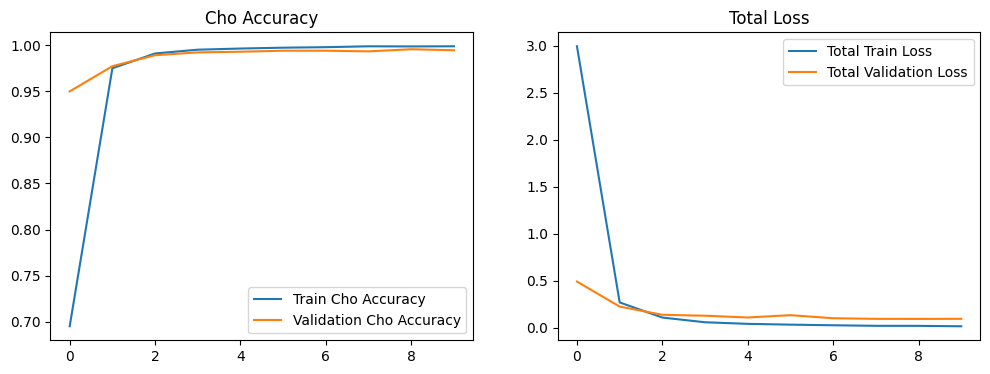

In [ ]:
#학습 과정 그래프로 보기
import matplotlib.pyplot as plt

# history = han_model.fit(...)

# 'history' 객체에는 loss, accuracy, val_loss, val_accuracy 등이 포함됩니다.
# 모델 출력이 3개이므로, 이름이 'cho_accuracy', 'jung_accuracy' 등으로 저장되어 있습니다.

# 예시: 'cho'(초성)의 정확도 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['cho_accuracy'], label='Train Cho Accuracy')
plt.plot(history.history['val_cho_accuracy'], label='Validation Cho Accuracy')
plt.title('Cho Accuracy')
plt.legend()

# 예시: 전체 손실(loss) 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Total Train Loss')
plt.plot(history.history['val_loss'], label='Total Validation Loss')
plt.title('Total Loss')
plt.legend()

plt.show()

In [15]:
# 직접 그린 이미지 테스트하기
from PIL import Image
import tensorflow as tf # Import tensorflow
import numpy as np # Import numpy
import os # Import os

# Re-instantiate the model if it's not already in memory, and load weights
if 'han_model' not in locals():
    # Assuming 'model' function is defined elsewhere in the notebook
    if 'model' not in locals():
        print("Error: 'model' function is not defined. Please ensure the model architecture is defined.")
        exit() # Exit if model function is not defined
    han_model = model((128,128,1))
    checkpoint_path = "training_checkpoints/11_03/model.weights.h5"
    try:
        han_model.load_weights(checkpoint_path)
        print("Model weights loaded successfully.")
    except tf.errors.NotFoundError:
        print(f"Error: Model weights file not found at {checkpoint_path}. Please ensure you have trained and saved the model.")
        exit() # Exit if weights are not found


# Specify the path to your image file
# Change this path to the location of your image in the Colab environment
image_path = 'test_image.png' # Example local path

# Load the image
try:
    img = Image.open(image_path).convert('L') # Convert to grayscale
    img_array = np.array(img)

    # Preprocess the image to match the model's input shape and type
    # Resize, expand dimensions, and convert to boolean using TensorFlow operations
    img_array = np.expand_dims(img_array, axis=-1)
    img_array = tf.image.resize(img_array, (128, 128))
    # Use TensorFlow operations instead of NumPy's .astype()
    img_array = tf.cast(img_array == 255, dtype=tf.bool)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

    # Make predictions
    predictions = han_model.predict(img_array)

    # Get the predicted class for each output
    predicted_cho_index = np.argmax(predictions[0], axis=1)[0]
    predicted_jung_index = np.argmax(predictions[1], axis=1)[0]
    predicted_jong_index = np.argmax(predictions[2], axis=1)[0]

    # You'll need to map these indices back to the actual characters.
    # Assuming you have lists of characters for cho, jung, and jong in the correct order:
    # Example (replace with your actual character lists):
    cho_chars = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
    jung_chars = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
    jong_chars = [' ', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']


    predicted_cho = cho_chars[predicted_cho_index]
    predicted_jung = jung_chars[predicted_jung_index]
    predicted_jong = jong_chars[predicted_jong_index]


    print(f"Predicted Cho: {predicted_cho}, intex: {predictions[0]}")
    print(f"Predicted Jung: {predicted_jung}, intex: {predictions[1]}")
    print(f"Predicted Jong: {predicted_jong}, intex: {predictions[2]}")

except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}. Please provide a valid image path.")
except Exception as e:
    print(f"An error occurred during image processing or prediction: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Cho: ㅅ, intex: [[2.9928374e-10 2.0602411e-12 4.2665769e-07 5.0060470e-11 1.7867102e-13
  8.8760715e-10 8.8917263e-14 1.2906320e-11 2.3374508e-12 9.9992681e-01
  5.4030555e-05 1.7066090e-05 2.3897817e-07 1.1766371e-10 1.4867679e-06
  8.5861313e-10 1.4901738e-11 2.3948955e-12 4.7547108e-09]]
Predicted Jung: ㅏ, intex: [[9.9989843e-01 2.2843054e-05 8.6101556e-07 1.1423721e-09 1.3553261e-08
  9.1024228e-09 7.1164949e-11 6.4271544e-12 3.8743578e-06 4.6962410e-05
  6.9388549e-12 3.0900415e-12 7.4834050e-10 1.5725395e-07 7.2529079e-12
  3.5710209e-11 6.2141282e-08 2.0677985e-06 2.8846255e-06 1.0009782e-08
  2.1802320e-05]]
Predicted Jong: ㄴ, intex: [[3.6340371e-05 6.8675882e-07 3.6103138e-08 4.3967822e-07 9.9476337e-01
  2.2169555e-05 4.2034262e-08 4.4120005e-03 3.9245505e-04 1.1193141e-06
  7.5583756e-07 1.8944565e-11 1.5988580e-07 5.1280622e-08 1.8596137e-07
  1.5939602e-11 6.7126830e-06 3.9254780e-10 5.2518112e-07 8.4224575e-06
  2.5203198e-07 2